In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as sps
import scipy.integrate as si
import scipy.optimize as spo
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnpl

<h3>TDSE Forward Problem</h3>

In [2]:
# size of spatial domain
L = 10.0

# set number of real space grid points for plotting
nx = 1025
# spatial grid for the purposes of plotting
xvec = np.linspace(-L, L, nx)

# the basis functions used in our Fourier representation
# will be from n = -nF to n = nF
nF = 32
# matrix for converting Fourier basis coefficients to real space values
Fnvec = np.arange(-nF, nF + 1) # Fnvec=-nfb,...,0,...,nfb
Fcnvrtmat = np.exp(1j * np.pi * np.outer(Fnvec, xvec) / L) / np.sqrt(2 * L)

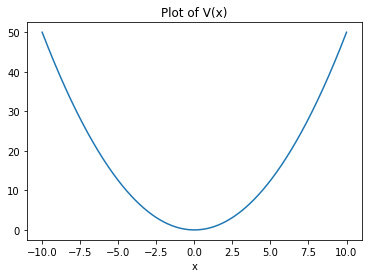

In [3]:
# define potential for generating training data

def v(x):
    # dimensionless quantum harmonic oscillator potential
    return 0.5 * x**2
    # rescaled symmetric double well potential
    # return 0.0025*(x**2 - 25)**2
    # scaled asymmetric double well potential
    # return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# compute true potential
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [4]:
def mkvtoeprowfft(vfn):
    # res adjusts the Fourier transform resolution
    # if res = 1, then nsamples = 2 * nF, which is the
    # Nyquist frequency (most course resolution?)
    res = 100
    nsamples = res * 2 * nF
    x = np.linspace(-L, L, nsamples + 2, endpoint=False)
    Fvvecfft = (np.fft.rfft(vfn(x)) / x.size)[:2 * nF +1]
    vtoeprow = Fvvecfft * (-1)**np.arange(2 * nF +1)
    return vtoeprow

In [5]:
def mkvtoeprowquad(vfn):
    vtoeprow = []
    for thisn in range(2 * nF +1):
        def intgrnd(x):
            return vfn(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        vtoeprow.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])
    return np.array(vtoeprow)

In [6]:
# THIS CELL IS ONLY MEANINGFUL IF v(x) is the SIMPLE HARMONIC OSCILLATOR
# this function computes the Fourier representation of harmonic oscillator
# exactly (thanks, Mathematica!)

def mkvtoeprowharm():
    # here is the exact result of the integral
    ecfun = lambda i: (L**2 * (2 * i * np.pi * np.cos(i * np.pi) + (-2 + i**2 * np.pi**2) * np.sin(i * np.pi))) / (2.0 * i**3 * np.pi**3)
    exactvrow = np.array(list(map(ecfun, np.arange(1, 2 * nF +1))))
    exactvrow = np.concatenate([np.array([L**2 / 6.0]), exactvrow])
    return exactvrow

# let us check which one is more accurate, FFT or quadrature
print('FFT vtoeprow vs. exact:', nl.norm(mkvtoeprowfft(v) - mkvtoeprowharm()), sep='\n')
print('Quad vtoeprow vs. exact:', nl.norm(mkvtoeprowquad(v) - mkvtoeprowharm()), sep='\n')
# we see that Fvmat is more accurate so we use that!

FFT vtoeprow vs. exact:
6.557417998345006e-06
Quad vtoeprow vs. exact:
7.393192790593471e-14


---
**Eigendecomposition of a Fourier Represented Potential**

In [7]:
# construct the kinetic matrix representation of the
# kinetic operator in the Fourier basis
# (this is constant for a given system)
kmat = np.diag(np.arange(-nF, nF + 1)**2 * np.pi**2 / (2 * L**2))

# use mkvtoeprowquad() to create Toeplitz matrix
vrowquad = mkvtoeprowquad(v)
Fvmat = sl.toeplitz(r=vrowquad, c=vrowquad.conj())

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
Fhmat = kmat + Fvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(Fhmat - Fhmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
Fspc, Fstts = nl.eigh(Fhmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(Fhmat @ Fstts - Fstts @ np.diag(Fspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(Fstts @ Fstts.T.conj() - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
3.392077258042753e-13
Unitary stts check (should be close to zero):
1.2469110651416776e-14


[0.5 1.5 2.5 3.5 4.5 5.5]


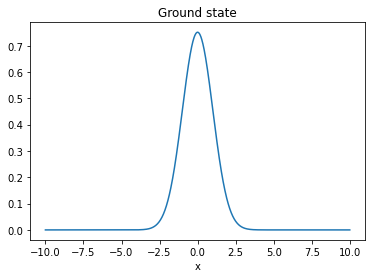

Quick check of normalization (should be close to 1):
0.9999999999999993
Check of normalization (should be close to 1):
0.9999999999999993


In [8]:
# find indices that sort eigenvalues
ordering = np.argsort(Fspc)

# print the first few eigenvalues
print(Fspc[ordering[:6]])

# pick out and plot ground state
groundstate = ordering[0]
wavefn = Fstts[:,groundstate] @ Fcnvrtmat
plt.plot(xvec, np.real(wavefn))
plt.title('Ground state')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick check of normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

---
**Set up of the Chebyshev Representation**

[ 2.50000000e+01  4.73695157e-15  2.50000000e+01  3.55271368e-15
 -9.47390314e-15  2.13162821e-14 -5.92118946e-15  1.42108547e-14
 -1.06581410e-14  1.65793305e-14 -3.43428989e-14  2.13162821e-14]


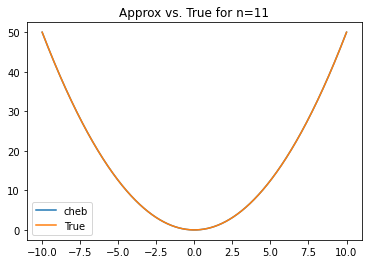

L-infinity Norm:
1.5631940186722204e-13


In [9]:
# let represents the potential function, v(x), using
# Chebyshev polynomials
# for the simple harmonic potential this should be
# exact because v(x) IS a polynomial

nc = 11

def theta(k):
    return (k - 0.5) * np.pi / (nc + 1)

def g(k):
    # cos(\theta) ranges from [-1, 1] which is the domain
    # of the Chebyshev interpolation function so we need to
    # modify v()'s so when it is given x \in [-1, 1], it
    # actually spans the domain [-L, L]
    # to do that, we multiply by np.cos(theta(k)) by L
    return v(L * np.cos(theta(k)))

kvec = np.arange(1, nc + 2)
cnvec = np.arange(0, nc + 1)

cweights = np.ones(nc + 1)
cweights[0] = 0.5

# compute Chebyshev coefficients
cvec = 2 / (nc + 1) * np.sum(g(kvec) * np.cos(cnvec[..., np.newaxis] * theta(kvec)), axis=1)
cvec = cweights * cvec
print(cvec)

ctoxmat = sps.eval_chebyt(np.expand_dims(cnvec, 0), np.expand_dims(xvec / L, 1))
vrec = ctoxmat @ cvec

# plot reconstruction vs truth
plt.plot(xvec, vrec, label='cheb')
plt.plot(xvec, vxvec, label='True')
plt.title(f'Approx vs. True for n={nc}')
plt.legend()
plt.show()

# Linfty norm error
print('L-infinity Norm:', np.max(np.abs(v(xvec) - vrec)), sep='\n')

---
**Form the Potential Matrix from the Chebyshev Representation**

In [10]:
# now form the entries of vmat from the Chebyshev
# representation by quadrature method

# this function returns the chebyshev approximation of
# the potential at some spatial point x, this is needed
# for transforming the Chebyshev coefficients to the
# Fourier representation by quadrature method
# def vchebaprx(x):
    # don't forget the interval of the argument x is [-L, L]
    # but for the chebyshev representation it needs to be
    # [-1, 1] so we need to divide x by L
    # return sps.eval_chebyt(np.expand_dims(cnvec, 0), x / L) @ cvec

# compute the Fourier representation of the Chebyshev
# coefficients of the true potential
# cvrowquad = np.zeros(2 * nF + 1, dtype=np.complex128)
# for thisn in range(2 * nF + 1):
#     def intgrnd(x):
#         return vchebaprx(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
#     def rintgrnd(x):
#         return intgrnd(x).real
#     def iintgrnd(x):
#         return intgrnd(x).imag
#     cvrowquad[thisn] = si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0]

cmat = np.zeros((2 * nF + 1, nc + 1), dtype=np.complex128)
for thiscn in range(nc + 1):
    for thisn in range(2 * nF + 1):
        def intgrnd(x):
            tvec = lambda x: sps.eval_chebyt(np.expand_dims(thiscn, 0), x / L)
            return tvec(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag

        cmat[thisn, thiscn] = si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0]

print(cmat.shape)

(65, 12)


In [11]:
cvrowquad = cmat @ cvec

# check how much cvrowquad differ from vrowquad
# (i.e., compare the potential in the Fourier representation
# to the potential in the Chebyshev representation which has
# been transformed to the Fourier representation)
print('L2 Norm Error:', nl.norm(vrowquad - cvrowquad))
print('L-infinity Error:', np.max(np.abs(vrowquad - cvrowquad)))


L2 Norm Error: 2.610274033911567e-13
L-infinity Error: 1.6643382799970866e-13


---
**Eigendecomposition of a Chebyshev Represented Potential**

In [12]:
# Let's compare the Hamiltonian matrix and its
# eigendecomposition for the Chebyshev representation
# of the potential to the Fourier representation of
# of the potential
cvmat = sl.toeplitz(r=cvrowquad, c=cvrowquad.conj())

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
chmat = kmat + cvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(chmat - chmat.T.conj()), sep='\n')

# eigendecomposition of the Hamiltonian matrix
cspc, cstts = nl.eigh(chmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(chmat @ cstts - cstts @ np.diag(cspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(cstts @ cstts.T.conj() - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
3.3579866970635153e-13
Unitary stts check (should be close to zero):
1.1902270981501877e-14


---
**Define the Initial Wave Function and Transform it to the Fourier Representation**

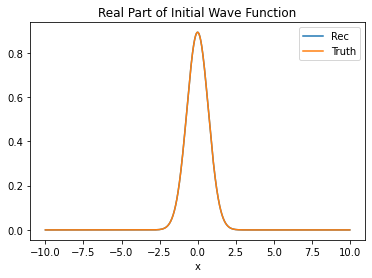

L2 Error: 7.817152898488495e-12
L-infinity Error: 4.1810999107383395e-13


In [13]:
# define initial state and transform to Fourier basis

def psi0(x):
    # rounded box function
    # return 1.0 + np.tanh((1 - x**2)/0.5)
    # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
    # parabolic pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
    # hyperbolic secant squared
    # return (np.cosh(x))**(-2)
    # Laplace
    # return np.exp(-np.abs(x))
    # a Gaussian with L^2 norm = 1
    # HSB's "super simple initial condition"
    return np.exp(-x**2) * (2.0 / np.pi)**0.25

# WHEN NOT USING GAUSSIAN WITH L^2 NORM = 1
# compute psi0 normalization term
# psi0probintgrnd = lambda x: np.abs(psi0(x))**2
# psi0normtrm = np.sqrt(si.quad(psi0probintgrnd, -L, L)[0])
# define function for computing normalized psi
# via scipy.integrate methods
# def normpsi0fn(x):
#     return psi0(x)/psi0normtrm

# WHEN USING GAUSSIAN WITH L^2 NORM = 1
normpsi0fn = psi0

# compute the Fourier basis representation of the
# normalized psi0 function using quadrature method
normpsi0quad = np.zeros(nF + 1, dtype=np.complex128)
for thisn in range (nF + 1):
    def intgrnd(x):
        return normpsi0fn(x) * np.exp(-1j * np.pi * thisn * x / L) / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    normpsi0quad[thisn] = si.quad(rintgrnd, -L, L)[0] + 1j*si.quad(iintgrnd, -L, L)[0]

ainit = np.concatenate([np.conjugate(np.flipud(normpsi0quad[1:])), normpsi0quad])

normpsi0vecrec = ainit @ Fcnvrtmat
normpsi0vec = normpsi0fn(xvec)

# plot the real part of the normalized psi0
plt.plot(xvec, normpsi0vecrec.real, label="Rec")
plt.plot(xvec, normpsi0vec.real, label="Truth")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('L2 Error:', nl.norm(normpsi0vecrec - normpsi0vec))
print('L-infinity Error:', np.max(np.abs(normpsi0vecrec - normpsi0vec)))

---
<h3>Foward Propagation</h3>

In [14]:
# solve the forward problem in the Fourier
# representation and store the trajectory
# in Famat

# set the size of a time step
dt = 1e-2

# set the number of time steps to take starting from
# the initial state (a single trajectory should be
# nts + 1 states, this includes the initial state)
ntsteps = 100


---
**Forward Propagation of ainit using the Potential in Fourier Representation**

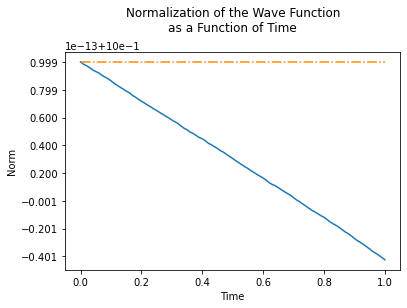

Average Norm of Trajectory (should be close to 1):
0.9999999999999298


In [15]:
# compute the propagator matrix reusing the
# spectrum and states from the eigendecomposition
# of Hamiltonian matrix computed above
Fpropa = Fstts @ np.diag(np.exp(-1j * Fspc * dt)) @ Fstts.conj().T

# propagate the system starting from the initial "a" state
Famat = np.zeros((ntsteps + 1, 2 * nF + 1), dtype=np.complex128)
Famat[0] = ainit.copy()
for i in range(ntsteps):
    Famat[i + 1] = Fpropa @ Famat[i]

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
Fpsimat = Famat @ Fcnvrtmat

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
Fpsimatnormvec = si.trapezoid(np.abs(Fpsimat) ** 2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, Fpsimatnormvec)
plt.hlines(1 , 0, ntsteps * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', Fpsimatnormvec.sum() / (ntsteps + 1), sep='\n')

---
**Forward Propagation of ainit using the Potential in the Cheybshev Representation**

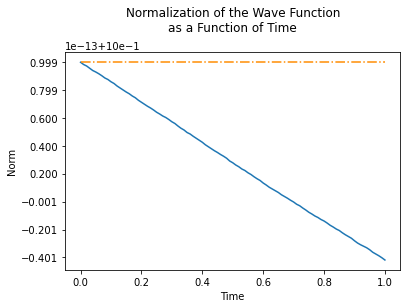

Average Norm of Trajectory (should be close to 1):
0.9999999999999284


In [16]:
# solve the forward problem in the Chebyshev
# representation and store the trajectory
# in camat

# compute the propagator matrix reusing the
# spectrum and states from the eigendecomposition
# of Hamiltonian matrix computed above
# cspc, cstts
cpropa = cstts @ np.diag(np.exp(-1j * cspc * dt)) @ cstts.conj().T

# propagate the system starting from the initial "a" state
camat = np.zeros((ntsteps + 1, 2 * nF + 1), dtype=np.complex128)
camat[0] = ainit.copy()
for i in range(ntsteps):
    camat[i + 1,:] = cpropa @ camat[i,:]

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
cpsimat = camat @ Fcnvrtmat

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
cpsimatnormvec = si.trapezoid(np.abs(cpsimat) ** 2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, cpsimatnormvec)
plt.hlines(1 , 0, ntsteps * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', cpsimatnormvec.sum() / (ntsteps + 1), sep='\n')

---

L2 Error of cpsimat to Fpsimat (should be close to 0):
2.3803984514365406e-12


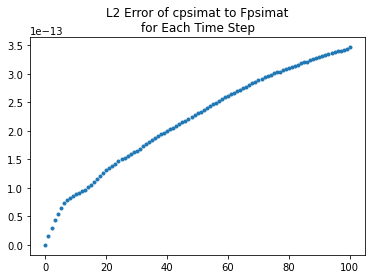

L2 Error of camat to Famat (should be close to 0):
3.3265773731704917e-13


In [17]:
# evaluate the difference of the forward propagation of
# the potential in the Fourier representation to the
# potential in the Chebyshev representation

print('L2 Error of cpsimat to Fpsimat (should be close to 0):', nl.norm(Fpsimat - cpsimat), sep='\n')

plt.plot(nl.norm(Fpsimat - cpsimat, axis=1), '.')
plt.title('L2 Error of cpsimat to Fpsimat\nfor Each Time Step')
plt.show()

print('L2 Error of camat to Famat (should be close to 0):', nl.norm(Famat - camat), sep='\n')

# plt.plot(nl.norm(camat - Famat, axis=1), '.')
# plt.title('L2 Error of camat to Famat\nfor Each Time Step')
# plt.show()


---
<h3>Inverse Problem - Adjoint Method</h3>

In [18]:
# form the entries of vmat from the Chebyshev
# representation by quadrature method

# def ctoF(cffs):
    # this function returns the chebyshev approximation give
    # a set of chebyshev coefficients at some point x
    # this is needed for transforming the Chebyshev coefficients
    # to the Fourier representation by quadrature method
    # def caprx(x):
        # interval of the argument x is [-L, L] but the
        # chebyshev representation needs to be [-1, 1]
        # so we divide x by L
        # return sps.eval_chebyt(np.expand_dims(cnvec, 0), x / L) @ cffs

    # compute the Fourier representation of the Chebyshev
    # coefficients by quadrature method
    # Fcaprx = []
    # for thisn in range(2 * nF + 1):
    #     def intgrnd(x):
    #         return caprx(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
    #     def rintgrnd(x):
    #         return intgrnd(x).real
    #     def iintgrnd(x):
    #         return intgrnd(x).imag
    #     Fcaprx.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])

    # return jnp.array(Fcaprx, dtype=jnp.complex128)

# both these results were constructed the same way and with the same
# chebyshev coefficients so this should be zero (or super close to it)
# print('L2 Error:', jnpl.norm(cvrowquad - ctoF(cvec)))

In [19]:
# make the potential matrix from a set of chebyshev
# coefficients

# code need to make toeplitz matrix from the Fourier
# representation with JAX
# def Ftoeplitz(row):
#     numtoepelms = 2 * nF + 1
#     a = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
#     b = [np.arange(numtoepelms - 1, 2 * numtoepelms -1)]
#     toepindxmat = jnp.array(a + b)
#     flattoepvec = jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
#     return flattoepvec[toepindxmat]

numtoepelms = 2 * nF + 1
a = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
b = [np.arange(numtoepelms - 1, 2 * numtoepelms -1)]
toepindxmat = jnp.array(a + b)
print(toepindxmat.shape)

jaxcmat = jnp.array(cmat)
print(jaxcmat.shape)
# print(jaxcmat)

# def ctovmat(cffs):
#     cvrow = jaxcmat @ cffs
#     return Ftoeplitz(cvrow)

# both these results were constructed the same way and with the same
# chebyshev coefficients so this should be zero (or super close to it)
# print('L2 Error:', jnpl.norm(cvmat - ctovmat(cvec)))

(65, 65)
(65, 12)


In [20]:
def cobjfn(cffs):
    # construct the vmat from Chebyshev coefficients
    # vmat = ctovmat(cffs)
    cvrow = jaxcmat @ cffs
    flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])
    vmat = jnp.array(flattoepvec[toepindxmat])

    # construct the Hamiltonian matrix
    hmat = kmat + vmat

    # eigendecomposition of the Hamiltonian matrix
    spc, stts = jnpl.eigh(hmat)

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propamat = stts @ jnp.diag(jnp.exp(-1j * spc * dt)) @ stts.conj().T

    # propagate the system starting from ainit
    # using propamat, i.e., solve the forward problem
    amat = [ainit]
    for i in range(ntsteps):
        amat.append(propamat @ amat[i])

    # make python list of Fourier basis wave functions
    # a jax object
    amat = jnp.stack(amat)

    # compute the objective
    residue = amat - Famat
    objective = 0.5 * jnp.real(jnp.sum(residue.conj() * residue))

    return objective

In [21]:
# check if the objective function gives zero when the
# chebyshev coefficients of the true potential are fed in
# this should produce a result which is very close to zero
cobjfn(cvec)

DeviceArray(2.47876558e-25, dtype=float64)

In [22]:
jitcobjfn = jax.jit(cobjfn)

In [23]:
jitcobjfn(cvec)

DeviceArray(2.47876558e-25, dtype=float64)

In [24]:
jaccobjfn = jax.jit(jax.jacrev(cobjfn))

In [25]:
# check if the JAX grad of the objective function works
# this should give all zeros (or close to that)
jaccobjfn(cvec)

DeviceArray([ 1.06320589e-12,  1.52357761e-14, -1.06105642e-12,
             -4.52413548e-14,  1.05439428e-12,  7.38983103e-14,
             -1.04261849e-12, -1.00465206e-13,  1.02485103e-12,
              1.24414524e-13, -1.00009063e-12, -1.45475886e-13],            dtype=float64)

---
**Initialize with true coefficients perturbed by random normally distributed noise**

In [26]:
# easy test case: initialize theta with true theta perturbed with
# random normally distributed noise with a small variance.
# This should be easy for the optimizer to converge to a good minimum

seed = 1234  # set to None for random initialization
cfftrub = cvec.copy()
cfftrub += 0.25 * np.random.default_rng(seed).normal(size=cvec.shape)
# cfftrub += 5.0 * np.random.default_rng(seed).normal(size=cvec.shape)

In [27]:
print(cobjfn(cfftrub))
print(jaccobjfn(cfftrub))

1.4610407983946736
[-9.8319456  -0.03972502  9.75521934  0.11870942 -9.52906297 -0.19620117
  9.16515042  0.27091713 -8.68168677 -0.34124206  8.10172642  0.40526617]


In [35]:
restrub = spo.minimize(cobjfn, cfftrub, jac=jaccobjfn, tol=1e-12, options={'maxiter': 200, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 108
         Function evaluations: 160
         Gradient evaluations: 149


cvec:
[ 2.50000000e+01  4.73695157e-15  2.50000000e+01  3.55271368e-15
 -9.47390314e-15  2.13162821e-14 -5.92118946e-15  1.42108547e-14
 -1.06581410e-14  1.65793305e-14 -3.43428989e-14  2.13162821e-14]
learned:
[ 2.50479878e+01 -8.08239602e-02  2.50204067e+01  2.71431986e-01
 -9.53780541e-02  4.89541266e-01 -1.09129166e-01  3.62131141e-01
 -5.03545805e-02  1.34603707e-01 -9.02271061e-03  2.08288468e-02]
Initial cffs L2 error: 1.128349350978641
Learned cffs L2 error: 0.7041958870019621
Initial cffs L-infinity error: 0.7282748056259928
Learned cffs L-infinity error: 0.4895412656958722
objective for results: 3.1572739777493438e-12
grad norm for results: 3.851960576179881e-11
grads for results:
[ 2.07284317e-11 -1.58123827e-12 -8.62655050e-12 -1.56506205e-12
  3.63801094e-12  7.25672601e-12 -2.58338889e-11 -1.44822878e-12
  7.06110383e-12  4.23591917e-12 -1.29586502e-11 -1.90101307e-12]


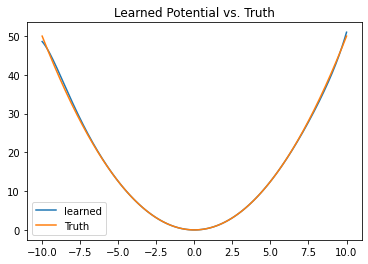

In [36]:
print('cvec:', cvec, sep='\n')
print('learned:', restrub, sep='\n')

print('Initial cffs L2 error:', nl.norm(cvec - cfftrub))
print('Learned cffs L2 error:', nl.norm(cvec - restrub))
print('Initial cffs L-infinity error:', np.max(np.abs(cvec - cfftrub)))
print('Learned cffs L-infinity error:', np.max(np.abs(cvec - restrub)))

print('objective for results:', cobjfn(restrub))
print('grad norm for results:', nl.norm(jaccobjfn(restrub)))
print('grads for results:', jaccobjfn(restrub), sep='\n')

# plot learned vs true
# plt.plot(xvec, ctoxmat @ cfftrub, label='initial')
plt.plot(xvec, ctoxmat @ restrub, label='learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---

In [46]:
def adjhelper(cffs):
    # construct the vmat from Chebyshev coefficients
    # function which returns the chebyshev approximation
    # given a set of coefficients
    def vcaprx(x):
        # don't forget that the chebyshev representation's
        # interval is x \in [-1, 1]
        return sps.eval_chebyt(np.expand_dims(cnvec, 0), x / L) @ cffs

    cvrow = []
    for thisn in range(2 * nF + 1):
        def intgrnd(x):
            return vcaprx(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
        def rintgrnd(x):
            return jnp.real(intgrnd(x))
        def iintgrnd(x):
            return jnp.imag(intgrnd(x))
        cvrow.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])

    # make the python list cvrow a jax object
    cvrow = jnp.stack(cvrow)

    # make toeplitz matrix by hand, so it's JAX grad/jacobian
    # compliant
    flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])
    # make potential matrix vmat from the Chebyshev coefficients
    vmat = flattoepvec[toepindxmat]

    # construct the Hamiltonian matrix in the
    # Fourier representation
    hmat = kmat + vmat

    # eigendecomposition of the Hamiltonian matrix
    spc, stts = jnpl.eigh(hmat)

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propamat = stts @ np.diag(np.exp(-1j * spc * dt)) @ stts.conj().T
    propHmat = stts @ np.diag(np.exp(1j * spc * dt)) @ stts.conj().T

    # propagate the system starting from ainit
    # using propamat, i.e., solve the forward problem
    amat = [ainit]
    for i in range(ntsteps):
        amat.append(propamat @ amat[i])

    # make python list of Fourier basis wave functions
    # a jax object
    amat = jnp.stack(amat)

    # propagate the "lambda" vector of coefficients backward
    # in time, i.e., solve the adjoint problem
    lmat = [amat[ntsteps,:] - amat[ntsteps,:]]

    itr = 0 # forward evaluation of lmat
    for i in range(ntsteps - 1, -1, -1):
        lmat.append(amat[i,:] - Famat[i,:] + propHmat @ lmat[itr] )
        itr += 1

    lmat = jnp.flipud(jnp.stack(lmat))

    offdiagmask = jnp.ones((ntoepelm, ntoepelm)) - jnp.eye(ntoepelm)
    expspec = jnp.exp(-1j * dt * spc)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spc, spc)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(ntoepelm)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    myeye = jnp.eye(ntoepelm)
    ws = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    ctrmats = ws[toepindxmat]
    derivamats = jnp.einsum('ij,jkm,kl->ilm', stts.conj().T, ctrmats, stts) * jnp.expand_dims(mask, 2)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil', stts, derivamats, stts.conj().T)

    ws = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
    ws = ws[1:, :]
    ws = ws.T
    ctrmats = ws[toepindxmat]
    derivamats = jnp.einsum('ij,jkm,kl->ilm', stts.conj().T, ctrmats, stts) * jnp.expand_dims(mask, 2)
    alldmatimag = -1j*dt*jnp.einsum('ij,jkm,kl->mil', stts, derivamats, stts.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])

    return lmat, alldmat, amat

def cgradfn(cffs):
    lmat, alldmat, amat = adjhelper(cffs)
    # compute all entries of the gradient at once
    gradients = jnp.einsum('ij,ajk,ik->a', jnp.conj(lmat[1:, :]), alldmat, amat[:-1, :]).real
    return gradients